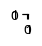

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# init / defs

In [2]:
DISTANCES=['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan','braycurtis', 'canberra', 'chebyshev', 'correlation', 
 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 
 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
KERNELS = ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']

In [4]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


In [5]:
ntcr = pd.read_csv('../data/NetTCR/new_train_df.csv')
ntcr = ntcr.drop(columns=['Unnamed: 0']).query('origin != "swapped"')
ntcr.to_csv('../data/filtered/231005_nettcr_pos_truenegs.csv', index=False)

In [6]:
df.sample(5)[['TRB_CDR3']]

,TRB_CDR3
1470,CASSITWTGNMNTEAFF
5639,CASSQDGWAGDQPQHF
587,CASRTGLASTDTQYF
20,CASSYRGTEAFF
1884,CASSTRSDSPLHF


In [7]:
from joblib import Parallel, delayed
from functools import partial
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df
        
def bruteforce(n_clusters, ODIR):
    km = KMeans(n_clusters, n_init=100, max_iter=500, random_state=13)
    train_clusters = km.fit_predict(z_train_30k)
    valid_clusters = km.predict(z_valid_30k)
    gil_clusters = km.predict(z_gil_30k)
    name = f'KM_n{n_clusters:02}'
    train_preds_30k[name] = train_clusters
    valid_preds_30k[name] = valid_clusters
    gil_preds_30k[name] = gil_clusters
    train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
    valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
    gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
    train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
    train_df.to_csv(f'{ODIR}train_df_{name}.csv')
    valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
    valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
    gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
    gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')
    
    for kernel in tqdm(['rbf', 'laplacian', 'cosine'], desc='sc kernel', position=1, leave=False):
        sc = SpectralClustering(n_clusters, affinity=kernel, n_init=30, random_state=13,n_jobs=1)
        clusters = sc.fit_predict(np.concatenate([z_train_30k, z_valid_30k, z_gil_30k], axis=0))
        train_clusters = clusters[:len(z_train_30k)]
        valid_clusters = clusters[len(z_train_30k): len(z_train_30k)+len(z_valid_30k)]
        gil_clusters = clusters[len(z_train_30k)+len(z_valid_30k):]
        name = f'SC_{kernel}_n{n_clusters:02}'
        train_preds_30k[name] = train_clusters
        valid_preds_30k[name] = valid_clusters
        gil_preds_30k[name] = gil_clusters
        train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
        valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
        gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
        train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
        train_df.to_csv(f'{ODIR}train_df_{name}.csv')
        valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
        valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
        gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
        gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')

In [8]:
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df

# def and checks

In [79]:
summary_dfs_all = pd.read_csv('../output/cluster_analysis/summary_dfs_all.csv')
summary_dfs_top10 = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')

In [80]:
summary_dfs_all.head()

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
0,0,KLGGALQAK,19.512195,164,0,train,ClXaM,2.581458
1,1,KLGGALQAK,16.317992,239,0,train,ClXaM,3.762002
2,2,GILGFVFTL,27.391304,230,0,train,ClXaM,3.620337
3,3,AVFDRKSDAK,14.093960,149,0,train,ClXaM,2.345349
4,4,GILGFVFTL,16.528926,121,0,train,ClXaM,1.904612


In [109]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [111]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [110]:
summary_dfs_all.query('purity_percent>90')

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
1675,14,GILGFVFTL,100.000000,1,4,valid,B6jIc,0.015741
2005,6,IVTDFSVIK,92.592593,54,2,train,3jETu,0.849992
2109,6,IVTDFSVIK,94.736842,19,1,valid,LKzfT,0.299071
2226,19,IVTDFSVIK,93.750000,16,0,valid,x8CyX,0.251850
2733,6,KLGGALQAK,100.000000,1,0,valid,KtR1W,0.015741
2758,5,IVTDFSVIK,94.736842,19,1,valid,KtR1W,0.299071


In [90]:
summary_dfs_top10.query('set=="valid" and purity_percent>50 and cluster_size>12').groupby('run_id')\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,count
run_id,
KtR1W,5
NnzVv,5
x8CyX,5
3jETu,4
A0dGE,3


In [92]:
summary_dfs_all.query('set=="valid" and purity_percent>50 and cluster_size>10').groupby(['run_id', 'partition'])\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,,count
run_id,partition,
j0xLE,1,6
ClXaM,4,5
3jETu,4,4
LKzfT,3,4
KtR1W,2,3


# GLIPH

In [507]:
gliph = pd.read_csv('../output/GLIPH/GLIPH_KCV_POS_ONLY.csv')
gliph = gliph[[x for x in gliph.columns if 'HLA' not in x]]
gliph

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
0,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsTGELF,CASSIRSTGELF,TRBV19,TRBJ2-2,CAVTYGGSQGNLIF,51/8030:GILGFVFTL,1.0
1,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsNTEAFF,CASSIRSNTEAFF,TRBV19,TRBJ1-1,CAGDSGGGSQGNLIF,99/1201:GILGFVFTL,1.0
2,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAGGGDGGSQGNLIF,83/6796:GILGFVFTL,1.0
3,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAESIGRGSQGNLIF,65/8923:GILGFVFTL,1.0
4,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsddIQYF,CASSIRSDDIQYF,TRBV19,TRBJ2-4,CGTADGGSQGNLIF,59/6999:GILGFVFTL,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,4780,single,1.0,11,1,9.500000e-07,1.0,0.001,1.0,0.001,0.950000,global-SSRDGGTDT,CASSSrdGGTDTQYF,CASSSRDGGTDTQYF,TRBV7-9,TRBJ2-3,CAGGGSQGNLIF,12/7884:GILGFVFTL,1.0
4178,4780,single,1.0,11,1,9.500000e-07,1.0,0.001,1.0,0.001,0.950000,global-SSRDGGTDT,CASSSrdGGTDTQYF,CASSSRDGGTDTQYF,TRBV7-9,TRBJ2-3,CAAPYGGSQGNLIF,87/9853:GILGFVFTL,1.0
4179,4780,single,1.0,11,1,9.500000e-07,1.0,0.001,1.0,0.001,0.950000,global-SSRDGGTDT,CASSSrdGGTDTQYF,CASSSRDGGTDTQYF,TRBV7-9,TRBJ2-3,CAGAGSGYALNF,47/4997:RAKFKQLL,1.0
4180,4780,single,1.0,11,1,9.500000e-07,1.0,0.001,1.0,0.001,0.950000,global-SSRDGGTDT,CASSSrdGGTDTQYF,CASSSRDGGTDTQYF,TRBV7-9,TRBJ2-3,CAVRDHSGNTPLVF,10/2585:RAKFKQLL,1.0


# TCR pepkernel similarity adj matrix

In [26]:
adj_matrix = pd.read_csv('../data/filtered/230929_nettcr_pos_adj_matrix.csv', index_col='A')
adj_matrix.head()

,CAAGDANTGELFF,CAAGGGGTEKLFF,CAAGQGNTGELFF,CAAGSSGNQPQHF,CAAGTRTDTQYF,CAAGTSGRVGEQFF,CAAGWGIGTEAFF,CAAQNGNPNEKLFF,CAASGRASETQYF,CACPPEEGGHYGYTF,...,CSVYLNTEAFF,CSYSAGEDQPQHF,CTSIAPIF,CTSKSGGPYEQF,CTSRDLGVWTEAF,CTSVPAAWDGASSYEQYF,CTSVPAVTVNFYGYTF,CTTSSGEADTQYF,CVPPYEKLTF,CVTGQGDINEQFF
A,,,,,,,,,,,,,,,,,,,,,
CAAGDANTGELFF,1.000000,0.833791,0.922672,0.808271,0.821413,0.832520,0.803848,0.805701,0.829519,0.698965,...,0.790501,0.772687,0.746653,0.785362,0.773166,0.716327,0.723947,0.820330,0.724117,0.820758
CAAGGGGTEKLFF,0.833791,1.000000,0.862865,0.797381,0.783272,0.818931,0.821764,0.771142,0.806494,0.682179,...,0.726746,0.737543,0.697982,0.788385,0.729241,0.676698,0.669484,0.771741,0.688156,0.780579
CAAGQGNTGELFF,0.922672,0.862865,1.000000,0.816436,0.808641,0.844086,0.814680,0.810145,0.820164,0.703386,...,0.772854,0.766710,0.725283,0.793320,0.756344,0.695332,0.705312,0.804836,0.710612,0.839774
CAAGSSGNQPQHF,0.808271,0.797381,0.816436,1.000000,0.800289,0.827664,0.754594,0.786589,0.836283,0.693642,...,0.733826,0.834720,0.713450,0.814682,0.726523,0.708205,0.680435,0.811575,0.698343,0.781084
CAAGTRTDTQYF,0.821413,0.783272,0.808641,0.800289,1.000000,0.819381,0.778730,0.758944,0.866828,0.677029,...,0.802260,0.779109,0.761954,0.786587,0.782478,0.706870,0.730053,0.848794,0.744953,0.794340


In [30]:
top10_pep = df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
top10_cdr3 = df.query('peptide in @top10_pep')['TRB_CDR3'].unique()
adj_top10 = adj_matrix.loc[top10_cdr3][top10_cdr3]

### spectral

In [32]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(26, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc = sc.fit_predict(adj_matrix)
sc = SpectralClustering(10, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc_top10 = sc.fit_predict(adj_top10)

In [59]:
sc_df = pd.DataFrame(np.array([adj_matrix.index, labels_sc]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df = pd.merge(df, sc_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary, sc_cluster_df = get_cluster_stats(sc_df, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

sc_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_sc_top10]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df_top10 = pd.merge(df, sc_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary_top10, sc_cluster_df_top10 = get_cluster_stats(sc_df_top10, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

### k-means

In [39]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import KMeans
km = KMeans(26, n_init=50, max_iter=500)
labels_km = km.fit_predict(adj_matrix)
km = KMeans(10, n_init=50, max_iter=500)
labels_km_top10 = km.fit_predict(adj_top10)

In [60]:
km_df = pd.DataFrame(np.array([adj_matrix.index, labels_km]).T, columns = ['TRB_CDR3', 'km_label'])
km_df = pd.merge(df, km_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary, km_cluster_df = get_cluster_stats(km_df, cluster='km_label', label='peptide', feature = 'B3', kf=False)

km_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_km_top10]).T, columns = ['TRB_CDR3', 'km_label'])
km_df_top10 = pd.merge(df, km_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary_top10, km_cluster_df_top10 = get_cluster_stats(km_df_top10, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [62]:
display(sc_summary_top10)
display(km_summary_top10)

,sc_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,25.986842,608,ALL,11.215643
1,1,GILGFVFTL,26.682692,416,ALL,7.673861
2,2,KLGGALQAK,23.750000,480,ALL,8.854455
3,3,IVTDFSVIK,17.325800,531,ALL,9.795241
4,4,GILGFVFTL,35.205479,730,ALL,13.466150
5,5,RAKFKQLL,31.319555,629,ALL,11.603025
6,6,RAKFKQLL,21.386139,505,ALL,9.315624
7,7,GILGFVFTL,19.646799,453,ALL,8.356392
8,8,KLGGALQAK,20.000000,510,ALL,9.407858
9,9,RAKFKQLL,19.499106,559,ALL,10.311751


,km_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,23.869347,398,ALL,7.341819
1,1,RAKFKQLL,18.454936,466,ALL,8.596200
2,2,GILGFVFTL,33.050847,708,ALL,13.060321
3,3,RAKFKQLL,25.901639,915,ALL,16.878805
4,4,GILGFVFTL,43.193069,808,ALL,14.904999
5,5,AVFDRKSDAK,23.863636,88,ALL,1.623317
6,6,IVTDFSVIK,18.620690,435,ALL,8.024350
7,7,KLGGALQAK,20.033389,599,ALL,11.049622
8,8,KLGGALQAK,20.309051,453,ALL,8.356392
9,9,KLGGALQAK,17.967332,551,ALL,10.164176


# Hamming/levenshtein distance baseline

In [9]:
def reassign_label_duplicates(cdr3b, df):
    max_label = df.query('TRB_CDR3==@cdr3b').groupby('peptide').agg(count=('binder','count')).idxmax().item()
    return max_label

In [10]:
import numpy as np
from Levenshtein import distance as lvd

def pairwise_dist(seqs_a, seqs_b, fct):
    vectorized = np.vectorize(fct)
    return vectorized(seqs_a[:, np.newaxis], seqs_b)

In [ ]:
# Example usage:
# Need to redo with out duplicates otherwise we can too perfect clusters
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df['reassigned_label'] = df['TRB_CDR3'].apply(reassign_label_duplicates, df= df)
seqs_a = df.drop_duplicates(subset=['TRB_CDR3'])['TRB_CDR3'].values
seqs_b = df.drop_duplicates(subset=['TRB_CDR3'])['TRB_CDR3'].values
labels = df.drop_duplicates(subset=['TRB_CDR3'])['reassigned_label'].values
lvd_result_matrix = pairwise_dist(seqs_a, seqs_b, lvd)

In [857]:
lvd_matrix = pd.DataFrame(lvd_result_matrix, columns = seqs_a, index= seqs_a)
lvd_matrix['labels']=labels
lvd_matrix

,CASGTETQYF,CSARWGGGTDTQYF,CSARGLDRGTNEQYF,CASSPGTSIFVAEQYF,CASSPGSRGNIQYF,CASGKLAGVLSEQFF,CASSATGTHSFGYTF,CASSQDPGFGGGSYEQYF,CASSMQTSGSAYNEQFF,CASSRGRGGQYNEQFF,...,CASSVGLAGSNEQFF,CASSTGVYGYTF,CASSFWGRNVDTQYF,CASSFLGSRAEAFF,CASSLVVAGGPGTDTQYF,CASSVVGAGGYNEQFF,CASSPRSSYEQYF,CASSARSTGELFF,CASSTRATGELFF,labels
CASGTETQYF,0,6,8,8,7,9,8,11,11,9,...,9,6,7,9,9,10,7,8,7,KLGGALQAK
CSARWGGGTDTQYF,6,0,6,11,9,10,10,10,12,9,...,10,10,6,11,7,9,9,10,10,ELAGIGILTV
CSARGLDRGTNEQYF,8,6,0,9,7,9,11,10,11,8,...,7,11,10,11,11,9,8,9,9,AVFDRKSDAK
CASSPGTSIFVAEQYF,8,11,9,0,6,9,9,8,8,8,...,8,9,8,8,11,9,6,9,9,ELAGIGILTV
CASSPGSRGNIQYF,7,9,7,6,0,10,9,8,8,7,...,6,7,7,7,9,7,5,7,8,RAKFKQLL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASSLVVAGGPGTDTQYF,9,7,11,11,9,11,11,9,11,10,...,9,10,8,12,0,8,11,11,11,RAKFKQLL
CASSVVGAGGYNEQFF,10,9,9,9,7,7,10,8,6,4,...,4,8,9,8,8,0,8,8,7,GILGFVFTL
CASSPRSSYEQYF,7,9,8,6,5,9,9,7,7,7,...,7,7,7,7,11,8,0,5,6,GILGFVFTL
CASSARSTGELFF,8,10,9,9,7,8,8,11,9,8,...,7,7,9,6,11,8,5,0,2,GILGFVFTL


In [861]:
lvd_matrix.to_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv')

# Baselines ? 

## (Dis)Similarity matrix and Levenshtein Dist matrices

Because Agg Clustering uses DISTANCE matrix so need to compute dissimilarity through 1-sim

In [ ]:
sim_matrix = pd.read_csv('../data/baselines/230929_nettcr_pos_kernelsim_matrix.csv', index_col=0)
lvd_matrix = pd.read_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv', index_col=0)
dissim_matrix = 1-sim_matrix
dissim_matrix = pd.merge(dissim_matrix, lvd_matrix[['labels']], left_index=True, right_index=True)

# Get the labels so they're the same as the lvd matrix (because some duplicates might have been treated differently

# Here apparently the dissim matrix is not symmetrical (due to rounding errors, like x[i,j] = 0.26472, and x[j,i] = 0.26473
# So manually redo this shit with a stupid double loop
wtf = dissim_matrix.drop(columns=['labels']).copy()
for i in tqdm(range(len(wtf)), desc='x',position=0, leave=True):
    for j in range(len(wtf)):
        if j>=i:continue
        if wtf.iloc[i,j] != wtf.iloc[j,i]:
            wtf.iloc[i,j]=wtf.iloc[j,i]
dissim_matrix = pd.merge(wtf, lvd_matrix[['labels']], left_index=True, right_index=True)
dissim_matrix.head()

In [864]:
dissim_matrix.to_csv('../data/baselines/231006_nettcr_pos_unique_kernelDISSIM_matrix.csv')

In [866]:
len(dissim_matrix), len(lvd_matrix)

(5178, 5178)

In [867]:
# n_clusters ~= 2200 ; We have n_clusters = 4780 in GLIPH
# here I assume I want roughly half as many 
n_clusters = 2250

res_sim = {}
res_lvd = {}

for linkage in ['average', 'complete', 'single']:
    # Dissimilarity (pepkernel)
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_sim = ag.fit_predict(dissim_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([dissim_matrix.index, ag_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_sim_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[linkage]={}
    res_sim[linkage]['model'] = ag
    res_sim[linkage]['df'] = ag_df
    res_sim[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_sim_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', linkage, f"n_clusters={len(res_sim[linkage]['summary'][f'AG_sim_{linkage}_label'].unique())},\tn good clust={len(res_sim[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")
    # LVD
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_lvd = ag.fit_predict(lvd_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([lvd_matrix.index, ag_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_lvd_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[linkage]={}
    res_lvd[linkage]['model'] = ag
    res_lvd[linkage]['df'] = ag_df
    res_lvd[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_lvd_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd', linkage, f"n_clusters={len(res_lvd[linkage]['summary'][f'AG_lvd_{linkage}_label'].unique())},\tn good clust={len(res_lvd[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")

for cse in range(0, 10):
    # LVD
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_lvd = hdb.fit_predict(lvd_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([lvd_matrix.index, hdb_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_lvd_{cse}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[f'hdb_{cse}']={}
    res_lvd[f'hdb_{cse}']['model']=hdb
    res_lvd[f'hdb_{cse}']['df'] = hdb_df
    res_lvd[f'hdb_{cse}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_lvd_{cse}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd',cse, f"n_clusters={len(res_lvd[f'hdb_{cse}']['summary'][f'hdb_lvd_{cse}_label'].unique())},\tn good clust={len(res_lvd[f'hdb_{cse}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

for cse in np.arange(0, 1.2, 0.1):
    # Dissimilarity (pepkernel)
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_sim = hdb.fit_predict(dissim_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([dissim_matrix.index, hdb_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_sim_{cse:.1}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[f'hdb_{cse:.1}']={}
    res_sim[f'hdb_{cse:.1}']['model']=hdb
    res_sim[f'hdb_{cse:.1}']['df'] = hdb_df
    res_sim[f'hdb_{cse:.1}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_sim_{cse:.1}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', cse, f"n_clusters={len(res_sim[f'hdb_{cse:.1}']['summary'][f'hdb_sim_{cse:.1}_label'].unique())},\tn good clust={len(res_sim[f'hdb_{cse:.1}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

sim average n_clusters=2250,	n good clust=22
lvd average n_clusters=2250,	n good clust=27
sim complete n_clusters=2250,	n good clust=41
lvd complete n_clusters=2250,	n good clust=32
sim single n_clusters=2250,	n good clust=3
lvd single n_clusters=2250,	n good clust=2
lvd 0 n_clusters=25,	n good clust=0
lvd 1 n_clusters=25,	n good clust=0
lvd 2 n_clusters=25,	n good clust=0
lvd 3 n_clusters=25,	n good clust=0
lvd 4 n_clusters=25,	n good clust=0
lvd 5 n_clusters=15,	n good clust=0
lvd 6 n_clusters=10,	n good clust=0
lvd 7 n_clusters=6,	n good clust=0
lvd 8 n_clusters=3,	n good clust=0
lvd 9 n_clusters=3,	n good clust=0
sim 0.0 n_clusters=5,	n good clust=3
sim 0.1 n_clusters=5,	n good clust=3
sim 0.2 n_clusters=3,	n good clust=1
sim 0.30000000000000004 n_clusters=3,	n good clust=1
sim 0.4 n_clusters=3,	n good clust=1
sim 0.5 n_clusters=3,	n good clust=1
sim 0.6000000000000001 n_clusters=3,	n good clust=1
sim 0.7000000000000001 n_clusters=3,	n good clust=1
sim 0.8 n_clusters=3,	n good clus

In [868]:
res_sim['complete']['summary'].sort_values(['purity_percent', 'cluster_size'], ascending=False).head(25)

,AG_sim_complete_label,labels,purity_percent,cluster_size,partition,retention
445,445,GILGFVFTL,100.0,33,ALL,0.637312
980,980,GILGFVFTL,100.0,11,ALL,0.212437
277,277,YLQPRTFLL,100.0,8,ALL,0.154500
594,594,GILGFVFTL,100.0,8,ALL,0.154500
62,62,GILGFVFTL,100.0,7,ALL,0.135187
1114,1114,GILGFVFTL,100.0,7,ALL,0.135187
114,114,GLCTLVAML,100.0,6,ALL,0.115875
180,180,NLVPMVATV,100.0,5,ALL,0.096562
604,604,ELAGIGILTV,100.0,5,ALL,0.096562
966,966,KSKRTPMGF,100.0,5,ALL,0.096562


In [869]:
pkl_dump(res_sim, '../output/cluster_analysis/231005_BASELINE_DISSIMILARITY.pkl')
pkl_dump(res_lvd, '../output/cluster_analysis/231005_BASELINE_LEVENSHTEIN.pkl')

/Users/riwa/Documents/code/tclustr/output/cluster_analysis/231005_BASELINE_DISSIMILARITY.pkl saved.
/Users/riwa/Documents/code/tclustr/output/cluster_analysis/231005_BASELINE_LEVENSHTEIN.pkl saved.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


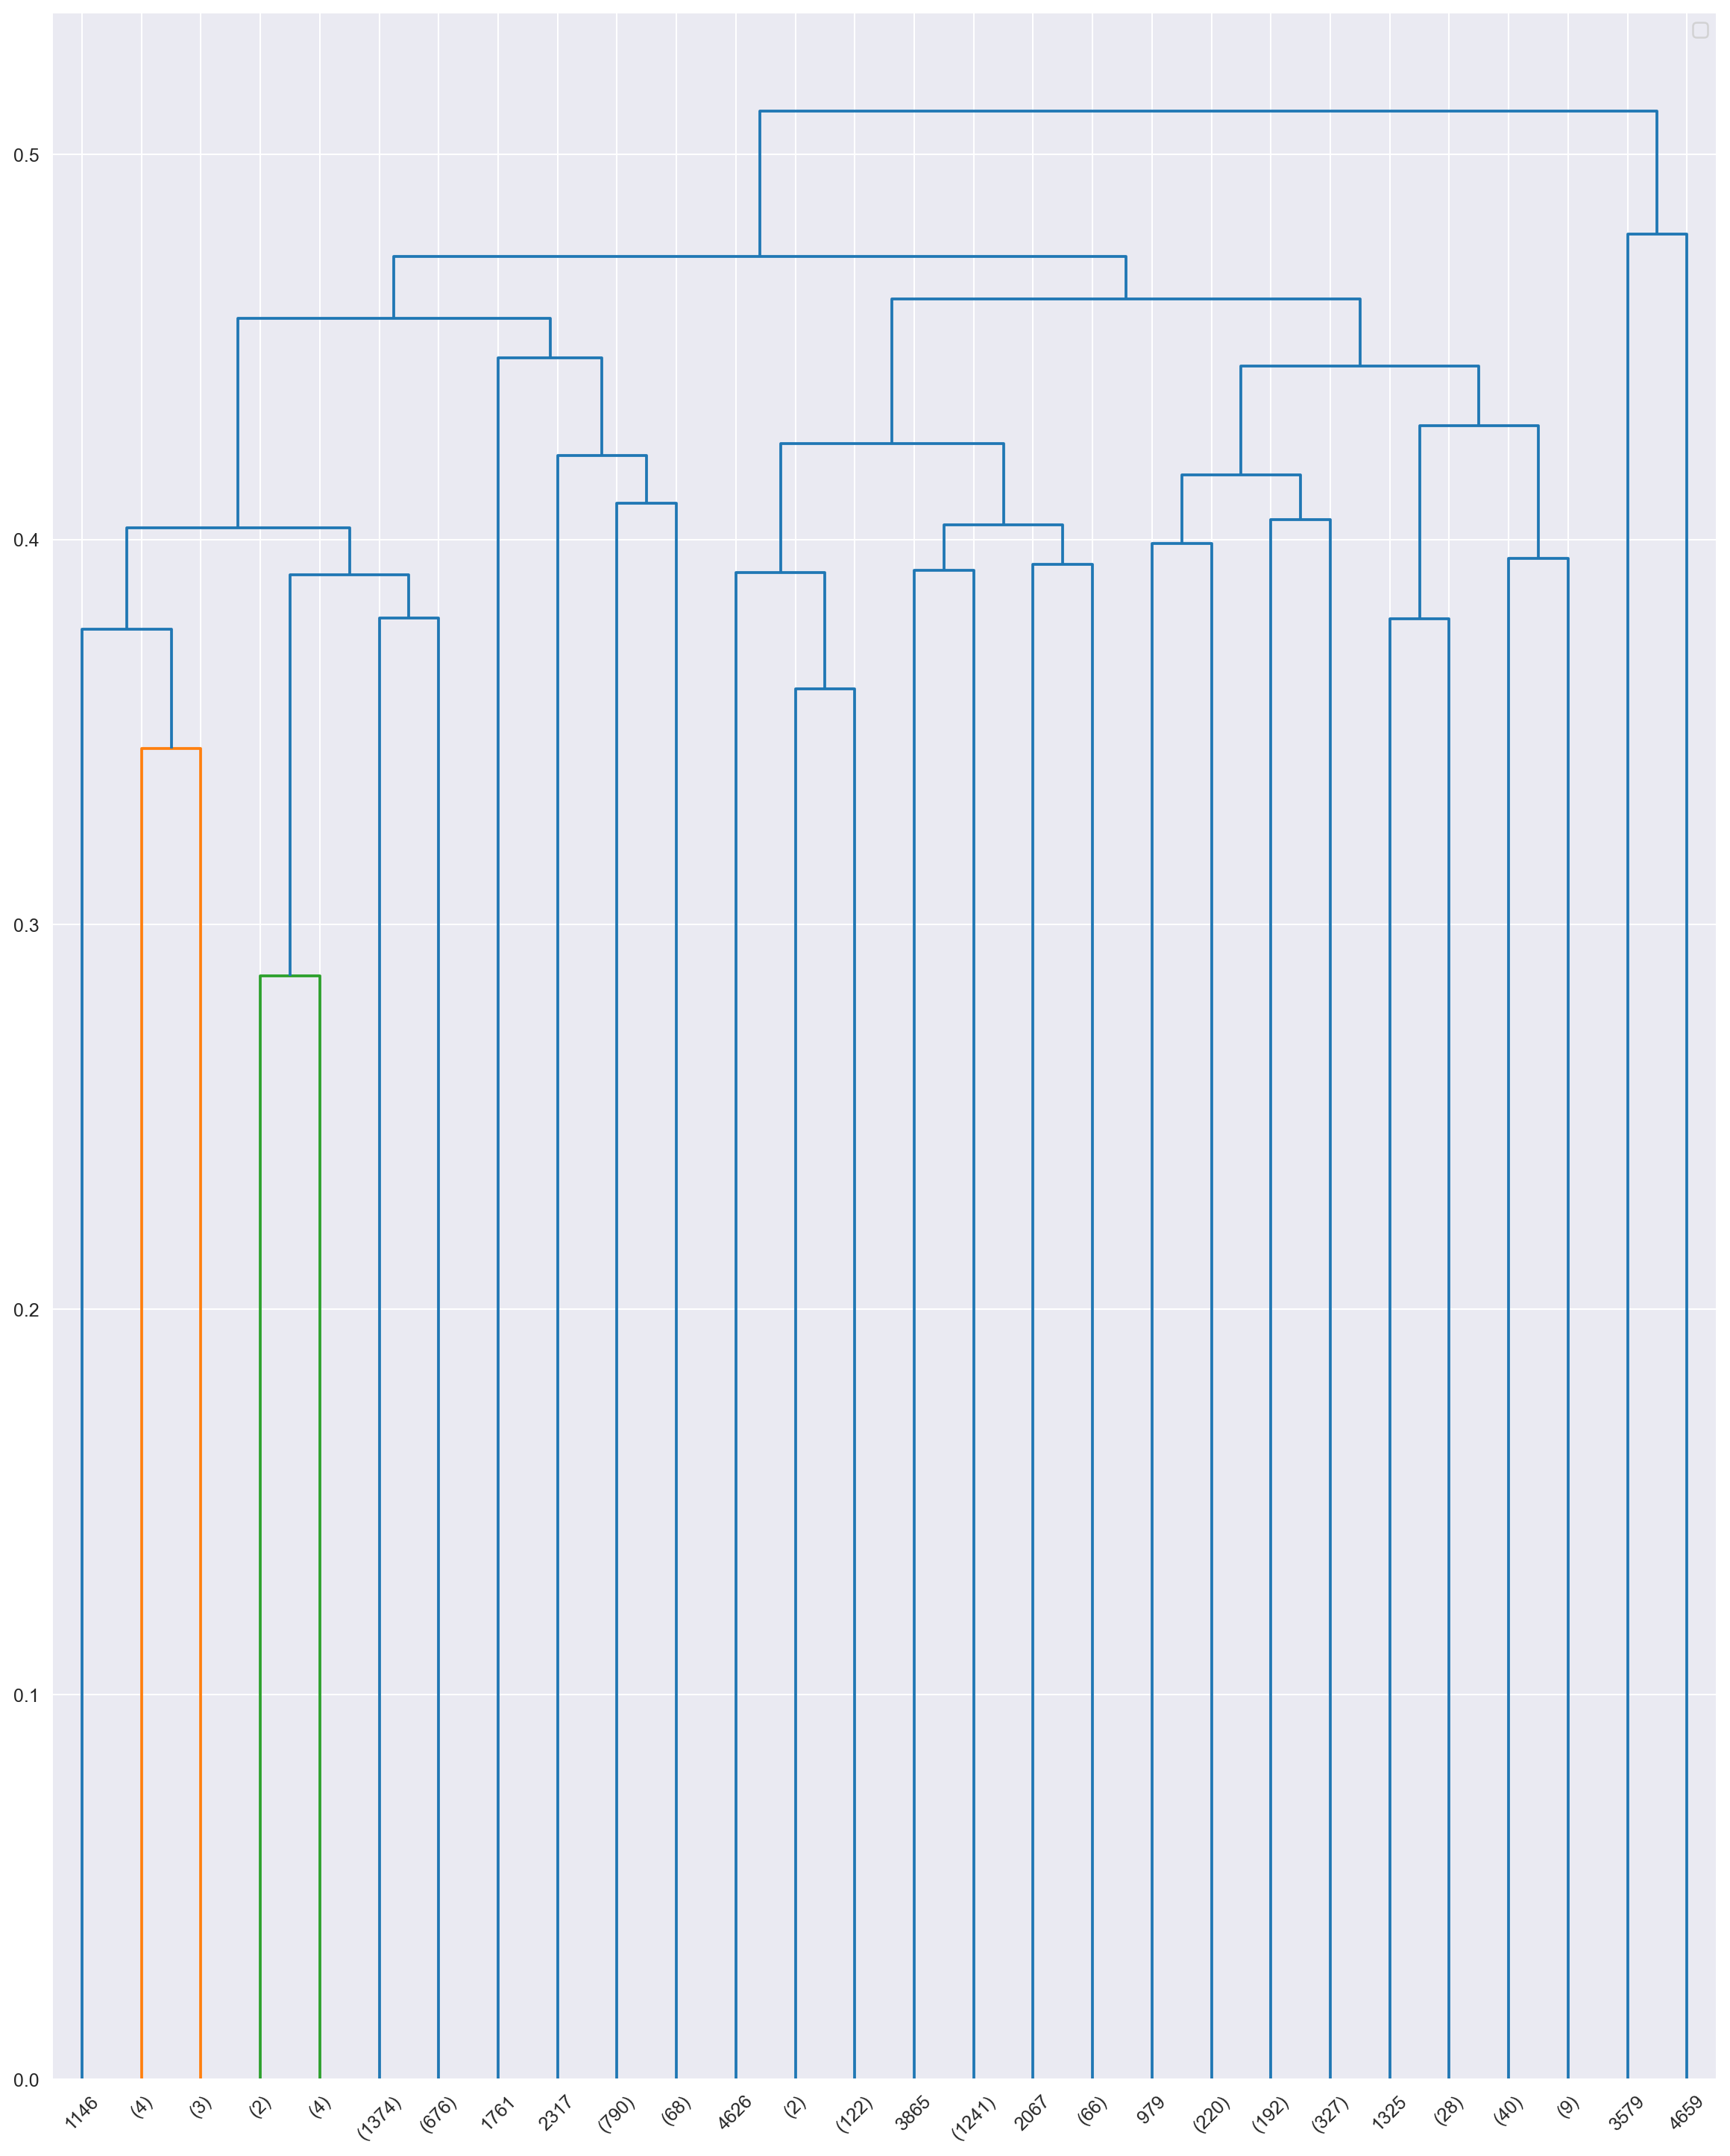

In [870]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    f,a = plt.subplots(1,1, figsize=(16,20))
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, ax=a)
    a.legend()
    return f,a
f,a = plot_dendrogram(res_sim['complete']['model'], truncate_mode='level', p=5)

In [871]:
res_sim['complete']['summary'].groupby(['labels']).agg(n_clusters=('cluster_size', 'count'), total_count=('cluster_size','sum'), 
                                                       min_purity=('purity_percent', 'min'), max_purity=('purity_percent', 'max'),
                                                       mean_purity=('purity_percent','mean'), std_purity=('purity_percent', 'std'))


,n_clusters,total_count,min_purity,max_purity,mean_purity,std_purity
labels,,,,,,
ATDALMTGF,60,154,20.000000,100.0,66.861111,31.332750
AVFDRKSDAK,439,1078,14.285714,100.0,67.891270,30.313210
CINGVCWTV,133,265,16.666667,100.0,81.107812,26.525661
CTELKLSDY,30,58,25.000000,100.0,67.222222,30.080777
DATYQRTRALVR,42,99,20.000000,100.0,71.091437,30.606769
ELAGIGILTV,205,536,17.647059,100.0,72.789634,28.607847
FEDLRLLSF,11,15,50.000000,100.0,81.818182,25.226249
FEDLRVLSF,8,13,33.333333,100.0,72.916667,29.462783
GILGFVFTL,273,906,22.222222,100.0,75.876583,27.511683


# Latent analysis

Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

-  Note to self: KtR1W says it has add_pep but I'm 98% sure that add_pep had not been done correctly (I spent all morning of wednesday 231004 to fix it) so this is just 25k epochs of CDR3b.
-  Re-ran two scripts : AddPep 25K epochs, wd=1e-4 (ID = 4soiY) and Normal CDR3b 30k epochs, wd=1e-4 (ID = EDHpH)
-  FOR THE ANALYSIS: TAKE ONLY EDHpH just to check stuff --> Take fold that is stable, compare test and train latent for GILGFVCTL (pos and true negs)

New IDS :
1. CDR3b + Pep, latent 64, wd 1e-4, 25k Epochs (4soiY) <-- might be useless idk if I fucked something up here.
2. CDR3b, no pep, latent 64, wd 1e-4, 30k Epochs (EDHpH)
3. CDR3a+b+pep, latent 128, wd 1e-4, 20k Epochs (8wkOD)
4. CDR3a+b, no pep, latent 128, wd 1e-4, 20k Epochs (3Cilu)

Bisecting K-means could be useful

## Some init checks and latent extraction

In [781]:
summary_dfs_top10.query('run_id=="NnzVv"').sort_values('purity_percent', ascending=False).head(25)

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
113,3,GILGFVFTL,79.032258,124,1,valid,NnzVv,2.292899
320,0,GILGFVFTL,73.265306,490,2,train,NnzVv,9.060651
120,0,GILGFVFTL,72.222222,126,2,valid,NnzVv,2.329882
313,3,GILGFVFTL,67.315175,514,1,train,NnzVv,9.504438
133,3,GILGFVFTL,62.500000,88,3,valid,NnzVv,1.627219
338,8,GILGFVFTL,56.989247,372,3,train,NnzVv,6.878698
344,4,GILGFVFTL,56.325823,577,4,train,NnzVv,10.669379
144,4,GILGFVFTL,55.639098,133,4,valid,NnzVv,2.459320
333,3,GILGFVFTL,52.769679,343,3,train,NnzVv,6.342456
138,8,GILGFVFTL,51.111111,90,3,valid,NnzVv,1.664201


In [782]:
folder30k = '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/'
subfolders30k = sorted([f'{folder30k}{x}' for x in os.listdir(folder30k) if os.path.isdir(f'{folder30k}{x}') and 'store' not in x.lower()])

folder10k = '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/'
subfolders10k = sorted([f'{folder10k}{x}' for x in os.listdir(folder10k) if os.path.isdir(f'{folder10k}{x}') and 'store' not in x.lower()])
subfolders10k, subfolders30k


(['../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_0_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_1_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_2_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_3_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_4_230928_1820_NnzVv'],
 ['../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_0_231004_1726_EDHpH',
  '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_ED

In [905]:
# Just take fold == 2 and do something here...
from torch.utils.data import SequentialSampler
from src.torch_utils import load_checkpoint
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset

max_len, encoding, pad_scale, aa_dim = 25, 'BL50LO', -20, 20
hidden_dim, latent_dim = 128, 64
use_v, use_j = False,  False
fold=2
train = df.query('partition!=@fold')
train_dataset = CDR3BetaDataset(train, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
train_loader = train_dataset.get_dataloader(1024, SequentialSampler)
valid = df.query('partition==@fold')
valid_dataset = CDR3BetaDataset(valid, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
valid_loader = valid_dataset.get_dataloader(1024, SequentialSampler)
# take this as the "test set"
gil_testdf = ntcr.query('peptide=="GILGFVFTL" and CDR3b not in @train_preds_30k.TRB_CDR3.unique()')
gil_dataset = CDR3BetaDataset(gil_testdf, max_len, encoding, pad_scale, 'CDR3b', use_v, use_j)
gil_loader = gil_dataset.get_dataloader(1024, SequentialSampler)

In [931]:
from src.models import CDR3bVAE
# reloading models
print('30k')
model_30k = CDR3bVAE(max_len, encoding, pad_scale, aa_dim, use_v, use_j, hidden_dim=hidden_dim, latent_dim=latent_dim)
model_30k = load_checkpoint(model_30k, f'{subfolders30k[fold]}/checkpoint_best_fold{fold:02}_kcv_230927_nettcr_positives_only_f{fold:02}_30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_{fold}_231004_1756_EDHpH.pt')

model_30k.train()
train_preds_30k_repam = predict_model(model_30k, train_dataset, train_loader)
valid_preds_30k_repam = predict_model(model_30k, valid_dataset, valid_loader)
gil_preds_30k_repam = predict_model(model_30k, gil_dataset, gil_loader)


30k
25
Reloading best model:
Best epoch: 26660
Valid loss: {'total': 0.14889138590239878, 'reconstruction': 0.08501176325217732, 'kld': 0.06387961965124563}
total: 0.14889138590239878
reconstruction: 0.08501176325217732
kld: 0.06387961965124563
seq_accuracy: 0.9841359257698059
v_accuracy: 0
j_accuracy: 0


In [932]:
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model
# HERE: NEED TO TEST 2 THINGS ; WITH AND WITHOUT THE REPARAMETERISATION TRICK (i.e. set model to train and model to eval to get 2 different preds)

model_30k.eval(), 
train_preds_30k_norep = predict_model(model_30k, train_dataset, train_loader)
valid_preds_30k_norep = predict_model(model_30k, valid_dataset, valid_loader)
gil_preds_30k_norep = predict_model(model_30k, gil_dataset, gil_loader)

In [937]:
check1 = train_preds_30k_repam.loc[train_preds_30k_repam.duplicated(subset=['TRB_CDR3'], keep=False)].sort_values('TRB_CDR3',ascending=False).head(2)
check2 = train_preds_30k_norep.loc[train_preds_30k_norep.duplicated(subset=['TRB_CDR3'], keep=False)].sort_values('TRB_CDR3',ascending=False).head(2)
display(pd.concat([check1, check2]))
del check1, check2

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,z_54,z_55,z_56,z_57,z_58,z_59,z_60,z_61,z_62,z_63
2783,NSASDY,IRSNMDK,AETHSGGSNYKLT,SQVTM,ANQGSEA,SYSAGEDQPQH,1,RAKFKQLL,RAKFKQLL,TRAV13-2*01,...,-0.064639,1.712648,-0.269808,-1.070404,-0.781021,0.158886,0.620325,-1.181057,-1.018580,-0.712414
2841,KTLYG,LQKGGEE,GADGGGTYKYI,SQVTM,ANQGSEA,SYSAGEDQPQH,1,RAKFKQLL,RAKFKQLL,TRAV34*01,...,-0.225363,-1.256403,1.410100,1.363762,-0.043530,0.190399,1.218748,0.908588,-0.619152,0.355045
2783,NSASDY,IRSNMDK,AETHSGGSNYKLT,SQVTM,ANQGSEA,SYSAGEDQPQH,1,RAKFKQLL,RAKFKQLL,TRAV13-2*01,...,-0.047375,-0.024518,-0.008157,-0.032389,0.005203,0.247242,0.008917,0.016534,-1.008843,0.024828
2841,KTLYG,LQKGGEE,GADGGGTYKYI,SQVTM,ANQGSEA,SYSAGEDQPQH,1,RAKFKQLL,RAKFKQLL,TRAV34*01,...,-0.047375,-0.024518,-0.008157,-0.032389,0.005203,0.247242,0.008917,0.016534,-1.008843,0.024828


### Quick checks because of duplicated TRB_CDR3

For duplicated TRBCDR3, will re-assign as label the largest amount of peptides. If there are only 1 of each, then will pick one at random

In [844]:
query=train_preds_30k.loc[train_preds_30k.duplicated(subset='TRB_CDR3', keep=False)][['TRA_CDR3', 'TRB_CDR3', 'peptide']].sort_values('TRB_CDR3')

In [845]:
# here for example for this CDR3 the "true" epitope shuold be RAKFKQLL.
query.query('TRB_CDR3 == "CASSFSGNTGELFF"').groupby('peptide').count()

,TRA_CDR3,TRB_CDR3
peptide,,
GILGFVFTL,5,5
IVTDFSVIK,1,1
RAKFKQLL,77,77


In [846]:
train_preds_30k.query('TRB_CDR3=="CASSFSGNTGELFF"').groupby('peptide').agg(count=('binder','count')).idxmax().item()

'RAKFKQLL'

In [847]:
train_preds_30k.query('TRB_CDR3=="CASSQLGRGDNEQFF"')[['TRA_CDR3', 'TRB_CDR3', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'peptide']]

,TRA_CDR3,TRB_CDR3,TRAV,TRAJ,TRBV,TRBJ,peptide
2982,CAREHMDSNYQLIW,CASSQLGRGDNEQFF,TRAV9-2*01,TRAJ33*01,TRBV7-9*01,TRBJ2-1*01,AVFDRKSDAK
3418,CAASETSYDKVIF,CASSQLGRGDNEQFF,TRAV13-1*01,TRAJ50*01,TRBV7-9*01,TRBJ2-1*01,RAKFKQLL
5028,CAGAGGGSQGNLIF,CASSQLGRGDNEQFF,TRAV27*01,TRAJ42*01,TRBV7-9*01,TRBJ2-1*01,GILGFVFTL


In [848]:
def fct(x):
    return len(np.unique(x))
problems=query.groupby(['TRB_CDR3']).agg(n_pep = ('peptide',fct)).query('n_pep>2')
query.query('TRB_CDR3 in @problems.index').groupby(['TRB_CDR3', 'peptide']).count()

TRA_CDR3
TRB_CDR3            peptide             
CASSFSGNTGELFF      GILGFVFTL          5
                    IVTDFSVIK          1
                    RAKFKQLL          77
CASSIRSSYEQYF       AVFDRKSDAK         1
                    ELAGIGILTV         1
                    GILGFVFTL         60
                    IVTDFSVIK          1
                    RAKFKQLL           4
CASSITEGEDSVSTDTQYF GILGFVFTL          1
                    IVTDFSVIK          1
                    RAKFKQLL           2
CASSLDTQYF          GILGFVFTL          1
                    GLCTLVAML          1
                    RAKFKQLL           1
CASSLGVAGTNTGELFF   ELAGIGILTV         1
                    GILGFVFTL          1
                    GLCTLVAML          2
                    IVTDFSVIK          1
                    RAKFKQLL           3
CASSLMRGGTYNSPLHF   GILGFVFTL          3
                    GLCTLVAML          1
                    RAKFKQLL           3
CASSLRDGSEAFF       AVFDRKSDAK         1
                    GILGFVFTL          2
                    GLCTLVAML          1
                    RAKFKQLL          46
CASSPRDRERGEQYF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           2
CASSPVTGGGSGANVLTF  AVFDRKSDAK         1
                    GILGFVFTL          2
                    IVTDFSVIK          1
                    RAKFKQLL           2
CASSQEWLAVSTDTQYF   GILGFVFTL          2
                    IVTDFSVIK          1
                    RAKFKQLL           3
CASSQLGRGDNEQFF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           1
CASSSGLVSNTGELFF    GILGFVFTL          2
                    GLCTLVAML          5
                    IVTDFSVIK          1
CASSSLDVAGYEQYF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           4
CASSSTGGGEKDQPQHF   AVFDRKSDAK         1
                    GILGFVFTL          3
                    GLCTLVAML          2
                    IVTDFSVIK          1
                    RAKFKQLL           5
CASSTRSSYEQYF       GILGFVFTL          7
                    GLCTLVAML          1
                    LLWNGPMAV          1
                    RAKFKQLL           1
CASSVAVGTGSGANVLTF  GILGFVFTL          1
                    GLCTLVAML          1
                    RAKFKQLL           1
CASSVRSSMNTEAFF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           4
CATSTGDSNQPQHF      AVFDRKSDAK         2
                    GLCTLVAML          1
                    RAKFKQLL           1
CSASPGDYEQYF        GILGFVFTL          1
                    IVTDFSVIK          1
                    RAKFKQLL           2

In [850]:
# SEE AT THE VERY TOP FOR RE-ASSIGN LABEL BECAUSE I DO IT AS WELL FOR THE LVD MATRIX AS WELL AS THE SIM (DISSIM) MATRIX
query['test'] = query['TRB_CDR3'].apply(reassign_label_duplicates, df=train_preds_30k)

In [853]:
query.query('peptide!=test').sort_values('TRB_CDR3', ascending=False)

,TRA_CDR3,TRB_CDR3,peptide,test
4306,CAGHTGNQFYF,CSVGTGDWGEQYF,IVTDFSVIK,RAKFKQLL
829,CAENGGGGADGLTF,CSVGSGDHGEQFF,GLCTLVAML,RAKFKQLL
4395,CAESEGPTYTDKLIF,CSGLYQETQYF,RAKFKQLL,GILGFVFTL
4968,CAVHGYGQNFVF,CSASPGDYEQYF,IVTDFSVIK,RAKFKQLL
4086,CAASMGGGSQGNLIF,CSASPGDYEQYF,GILGFVFTL,RAKFKQLL
...,...,...,...,...
1814,CAFMKLAGANSKLTF,CASKSEKGAGGSPLHF,SLFNTVATLY,RAKFKQLL
1856,CAMSGDGGSQGNLIF,CASGRLSYNEQFF,GILGFVFTL,RAKFKQLL
2454,CADSGGGADGLTF,CASGMTGLTSEQYF,RAKFKQLL,GILGFVFTL
1335,CADSGGGADGLTF,CASAPDGFFYGYTF,RAKFKQLL,GILGFVFTL


## Latent comparisons with some pairwise metrics

In [278]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
def plot_latent(df, cols, hue):
    vars_ = cols
    print(f'VAE latent space representation for {cols[0]}-{cols[-1]}')
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle(f'VAE latent space representation for {cols[0]}-{cols[-1]}', fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot,  alpha=0.75)
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    f.tight_layout()
    plt.show()

def pairwise_dist(seqs_a, seqs_b, fct):
    vectorized = np.vectorize(fct)
    return vectorized(seqs_a[:, np.newaxis], seqs_b)


## Reassigning labels for ALL duplicates and drop dupes and saving

In [952]:
# See reassign fct above in section #1 init / defs

train_preds_30k_repam['set']='train'
valid_preds_30k_repam['set']='valid'
gil_preds_30k_repam_pos = gil_preds_30k_repam.query('binder==1').assign(set='gil_pos').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
gil_preds_30k_repam_neg = gil_preds_30k_repam.query('binder==0').assign(set='gil_neg').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
train_preds_30k_norep['set']='train'
valid_preds_30k_norep['set']='valid'
gil_preds_30k_norep_pos = gil_preds_30k_norep.query('binder==1').assign(set='gil_pos').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
gil_preds_30k_norep_neg = gil_preds_30k_norep.query('binder==0').assign(set='gil_neg').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})

train_preds_30k_repam['labels'] = train_preds_30k_repam['TRB_CDR3'].apply(reassign_label_duplicates, df= train_preds_30k_repam)
valid_preds_30k_repam['labels'] = valid_preds_30k_repam['TRB_CDR3'].apply(reassign_label_duplicates, df= valid_preds_30k_repam)
gil_preds_30k_repam_pos['labels'] = gil_preds_30k_repam_pos['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_repam_pos)
gil_preds_30k_repam_neg['labels'] = gil_preds_30k_repam_neg['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_repam_neg)
train_preds_30k_norep['labels'] = train_preds_30k_norep['TRB_CDR3'].apply(reassign_label_duplicates, df= train_preds_30k_norep)
valid_preds_30k_norep['labels'] = valid_preds_30k_norep['TRB_CDR3'].apply(reassign_label_duplicates, df= valid_preds_30k_norep)
gil_preds_30k_norep_pos['labels'] = gil_preds_30k_norep_pos['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_norep_pos)
gil_preds_30k_norep_neg['labels'] = gil_preds_30k_norep_neg['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_norep_neg)

In [953]:
del train_preds_30k, valid_preds_30k, gil_preds_30k_pos, gil_preds_30k_neg

In [965]:
# These are with duplicates !!
os.makedirs('../data/preds_30k/',exist_ok=True)
train_preds_30k_repam.to_csv('../data/preds_30k/train_preds_30k_reparameterised.csv', index=False)
valid_preds_30k_repam.to_csv('../data/preds_30k/valid_preds_30k_reparameterised.csv', index=False)
gil_preds_30k_repam_pos.to_csv('../data/preds_30k/gil_preds_30k_POSITIVES_reparameterised.csv', index=False)
gil_preds_30k_repam_neg.to_csv('../data/preds_30k/gil_preds_30k_NEGATIVES_reparameterised.csv', index=False)

train_preds_30k_norep.to_csv('../data/preds_30k/train_preds_30k_noreparam_mu_only.csv', index=False)
valid_preds_30k_norep.to_csv('../data/preds_30k/valid_preds_30k_noreparam_mu_only.csv', index=False)
gil_preds_30k_norep_pos.to_csv('../data/preds_30k/gil_preds_30k_POSITIVES_noreparam_mu_only.csv', index=False)
gil_preds_30k_norep_neg.to_csv('../data/preds_30k/gil_preds_30k_PONEGAVES_noreparam_mu_only.csv', index=False)

In [966]:
cat_repam = pd.concat([train_preds_30k_repam ,valid_preds_30k_repam, 
                          gil_preds_30k_repam_pos.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'}), 
                          gil_preds_30k_repam_neg.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'})]).drop_duplicates(subset=['TRB_CDR3'])
cat_repam['seq_id'] = [f'seq_{id:05}' for id in range(len(cat_repam))]
cat_norep = pd.concat([train_preds_30k_norep ,valid_preds_30k_norep, 
                          gil_preds_30k_norep_pos.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'}), 
                          gil_preds_30k_norep_neg.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'})]).drop_duplicates(subset=['TRB_CDR3'])
cat_norep['seq_id'] = [f'seq_{id:05}' for id in range(len(cat_norep))]
display(cat_norep.head())
display(cat_repam.head())

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,z_57,z_58,z_59,z_60,z_61,z_62,z_63,set,labels,seq_id
0,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,-0.037022,0.012112,0.919840,-0.009918,-0.006479,-2.497391,0.031239,train,ELAGIGILTV,seq_00000
1,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,-0.028032,0.008912,1.303658,-0.006796,-0.000062,0.632049,0.025875,train,AVFDRKSDAK,seq_00001
2,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,-0.004020,0.023565,-0.103526,0.012900,0.005799,3.214355,0.039064,train,ELAGIGILTV,seq_00002
3,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,-0.002554,0.010025,1.053022,-0.002714,-0.002268,-0.433950,0.006993,train,RAKFKQLL,seq_00003
4,DRGSQS,IYSNGD,ASPGGGADGLT,SGHDT,YYEEEE,ASSATGTHSFGYT,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,-0.006932,0.008597,1.758195,0.013911,0.019836,0.272313,-0.000623,train,ELAGIGILTV,seq_00004


,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,z_57,z_58,z_59,z_60,z_61,z_62,z_63,set,labels,seq_id
0,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,1.321671,0.263137,0.807252,0.123205,-0.228480,-2.778790,0.593435,train,ELAGIGILTV,seq_00000
1,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,0.951260,-0.420481,1.042142,-0.777457,1.242517,0.667326,0.598259,train,AVFDRKSDAK,seq_00001
2,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,1.607870,0.382154,-0.061401,-0.152138,-0.686362,3.225466,0.974028,train,ELAGIGILTV,seq_00002
3,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,-1.253203,1.600475,0.820530,-1.911506,-0.978183,-0.634139,-0.309554,train,RAKFKQLL,seq_00003
4,DRGSQS,IYSNGD,ASPGGGADGLT,SGHDT,YYEEEE,ASSATGTHSFGYT,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,0.173220,0.627348,1.934787,-0.576115,0.138916,0.283834,0.397887,train,ELAGIGILTV,seq_00004


In [968]:
cat_repam.to_csv('../data/preds_30k/231006_concat_no_dupes_preds_repam.csv', index=False)
cat_norep.to_csv('../data/preds_30k/231006_concat_no_dupes_preds_norep.csv', index=False)

## Running distances metrics for de-duped df 

In [11]:
cat_repam = pd.read_csv('../data/preds_30k/231006_concat_no_dupes_preds_repam.csv')
cat_norep = pd.read_csv('../data/preds_30k/231006_concat_no_dupes_preds_norep.csv')

In [791]:
%mkdir ../data/231006_latent_dists/

In [13]:
z_cols = [f'z_{i}' for i in range(64)]

In [14]:
Z_norep = cat_norep[z_cols].values
Z_repam = cat_repam[z_cols].values
seq_idx_cols = cat_repam.TRB_CDR3.values
labels = np.expand_dims(cat_repam.labels.values, 1)
ids = np.expand_dims(cat_repam.seq_id.values, 1)
sets = np.expand_dims(cat_repam.set.values, 1)

In [18]:
os.path.exists(f'{odir}231006_dist_manhattan_cat_repam.csv')

True

In [ ]:
from sklearn.metrics import pairwise_distances, pairwise_kernels
odir = '../data/231006_latent_dists/'
for kernel in tqdm(['rbf', 'laplacian', 'cosine'], desc='metric', position=0):
    out_repam = pairwise_kernels(X=Z_repam, metric=kernel)
    pd.DataFrame(np.concatenate([out_repam, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_kernel_{kernel}_cat_repam.csv')
    del out_repam  
    out_norep = pairwise_kernels(X=Z_norep, metric=kernel)
    pd.DataFrame(np.concatenate([out_norep, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_kernel_{kernel}_cat_norep.csv')
    del out_norep 

In [21]:
for distance in tqdm(['cosine', 'euclidean', 'manhattan', 'correlation', 'hamming', 'jaccard'], desc='metric', position=1):
    print(distance)
    if (os.path.exists(f'{odir}231006_dist_{distance}_cat_repam.csv') and os.path.exists(f'{odir}231006_dist_{distance}_cat_norep.csv')):continue
    out_repam = pairwise_distances(X=Z_repam, metric=distance)
    pd.DataFrame(np.concatenate([out_repam, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_dist_{distance}_cat_repam.csv')
    del out_repam 
    out_norep = pairwise_distances(X=Z_norep, metric=distance)
    pd.DataFrame(np.concatenate([out_norep, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_dist_{distance}_cat_norep.csv')
    del out_norep 


metric:   0%|                                                                                                            | 0/6 [00:00<?, ?it/s]

cosine
euclidean
manhattan
correlation



metric:  67%|██████████████████████████████████████████████████████████████████▋                                 | 4/6 [02:21<01:10, 35.31s/it]

hamming



metric:  83%|███████████████████████████████████████████████████████████████████████████████████▎                | 5/6 [03:06<00:37, 37.80s/it]

jaccard



metric: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:55<00:00, 39.27s/it]


In [24]:
pd.read_csv(

'norep'

In [867]:
# n_clusters ~= 2200 ; We have n_clusters = 4780 in GLIPH
# here I assume I want roughly half as many 
outdir='../output/231006_latent_analysis/'

n_clusters = 2250
files = [f'{odir}{x}' for x in os.listdir(odir)]
res_repam = {}
res_norep = {}

for linkage in ['average', 'complete', 'single']:
    name = file.split('cat_')[1].split('.csv')[0]
    # Dissimilarity (pepkernel)
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_sim = ag.fit_predict(dissim_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([dissim_matrix.index, ag_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_sim_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[linkage]={}
    res_sim[linkage]['model'] = ag
    res_sim[linkage]['df'] = ag_df
    res_sim[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_sim_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', linkage, f"n_clusters={len(res_sim[linkage]['summary'][f'AG_sim_{linkage}_label'].unique())},\tn good clust={len(res_sim[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")
    # LVD
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_lvd = ag.fit_predict(lvd_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([lvd_matrix.index, ag_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_lvd_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[linkage]={}
    res_lvd[linkage]['model'] = ag
    res_lvd[linkage]['df'] = ag_df
    res_lvd[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_lvd_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd', linkage, f"n_clusters={len(res_lvd[linkage]['summary'][f'AG_lvd_{linkage}_label'].unique())},\tn good clust={len(res_lvd[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")


sim average n_clusters=2250,	n good clust=22
lvd average n_clusters=2250,	n good clust=27
sim complete n_clusters=2250,	n good clust=41
lvd complete n_clusters=2250,	n good clust=32
sim single n_clusters=2250,	n good clust=3
lvd single n_clusters=2250,	n good clust=2
lvd 0 n_clusters=25,	n good clust=0
lvd 1 n_clusters=25,	n good clust=0
lvd 2 n_clusters=25,	n good clust=0
lvd 3 n_clusters=25,	n good clust=0
lvd 4 n_clusters=25,	n good clust=0
lvd 5 n_clusters=15,	n good clust=0
lvd 6 n_clusters=10,	n good clust=0
lvd 7 n_clusters=6,	n good clust=0
lvd 8 n_clusters=3,	n good clust=0
lvd 9 n_clusters=3,	n good clust=0
sim 0.0 n_clusters=5,	n good clust=3
sim 0.1 n_clusters=5,	n good clust=3
sim 0.2 n_clusters=3,	n good clust=1
sim 0.30000000000000004 n_clusters=3,	n good clust=1
sim 0.4 n_clusters=3,	n good clust=1
sim 0.5 n_clusters=3,	n good clust=1
sim 0.6000000000000001 n_clusters=3,	n good clust=1
sim 0.7000000000000001 n_clusters=3,	n good clust=1
sim 0.8 n_clusters=3,	n good clus

In [ ]:

for cse in range(0, 10):
    # LVD
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_lvd = hdb.fit_predict(lvd_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([lvd_matrix.index, hdb_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_lvd_{cse}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[f'hdb_{cse}']={}
    res_lvd[f'hdb_{cse}']['model']=hdb
    res_lvd[f'hdb_{cse}']['df'] = hdb_df
    res_lvd[f'hdb_{cse}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_lvd_{cse}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd',cse, f"n_clusters={len(res_lvd[f'hdb_{cse}']['summary'][f'hdb_lvd_{cse}_label'].unique())},\tn good clust={len(res_lvd[f'hdb_{cse}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

for cse in np.arange(0, 1.2, 0.1):
    # Dissimilarity (pepkernel)
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_sim = hdb.fit_predict(dissim_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([dissim_matrix.index, hdb_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_sim_{cse:.1}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[f'hdb_{cse:.1}']={}
    res_sim[f'hdb_{cse:.1}']['model']=hdb
    res_sim[f'hdb_{cse:.1}']['df'] = hdb_df
    res_sim[f'hdb_{cse:.1}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_sim_{cse:.1}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', cse, f"n_clusters={len(res_sim[f'hdb_{cse:.1}']['summary'][f'hdb_sim_{cse:.1}_label'].unique())},\tn good clust={len(res_sim[f'hdb_{cse:.1}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

# Bruteforce Stuff

In [298]:
train_preds_30k.columns.join(gil_preds_30k.columns,how='inner')

Index(['A1', 'A2', 'B1', 'B2', 'binder', 'peptide', 'partition', 'allele',
       'origin', 'len', 'seq_acc', 'hat_reconstructed', 'true_reconstructed',
       'n_errors_seq', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'z_16',
       'z_17', 'z_18', 'z_19', 'z_20', 'z_21', 'z_22', 'z_23', 'z_24', 'z_25',
       'z_26', 'z_27', 'z_28', 'z_29', 'z_30', 'z_31', 'z_32', 'z_33', 'z_34',
       'z_35', 'z_36', 'z_37', 'z_38', 'z_39', 'z_40', 'z_41', 'z_42', 'z_43',
       'z_44', 'z_45', 'z_46', 'z_47', 'z_48', 'z_49', 'z_50', 'z_51', 'z_52',
       'z_53', 'z_54', 'z_55', 'z_56', 'z_57', 'z_58', 'z_59', 'z_60', 'z_61',
       'z_62', 'z_63'],
      dtype='object')

In [386]:
sample_train = train_preds_30k.query('peptide=="GILGFVFTL"').sample(5)[[x for x in train_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_valid = valid_preds_30k.query('peptide=="GILGFVFTL"').sample(5)[[x for x in valid_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_gilpos = gil_preds_30k.query('peptide=="GILGFVFTL" and binder==1').sample(5)[[x for x in gil_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_gilneg = gil_preds_30k.query('peptide=="GILGFVFTL" and binder==0').sample(5)[[x for x in gil_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_else = train_preds_30k.query('peptide!="GILGFVFTL"').sample(10)[[x for x in train_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
z_cols = [f'z_{i}' for i in range(latent_dim)]

In [387]:
concat_vals = pd.concat([sample_train[z_cols], sample_else[z_cols], sample_valid[z_cols], sample_gilpos[z_cols], sample_gilneg[z_cols]])
dists=pairwise_distances(concat_vals, metric='euclidean')
df=pd.DataFrame(dists)
display(df.describe())
display(df)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,10.797566,12.424803,10.984614,11.884706,10.928858,11.315497,10.861196,11.417501,11.427678,12.304549,...,10.816254,10.924729,11.713161,12.078811,10.847827,12.792547,12.764506,11.124900,11.275655,11.761539
std,2.329527,2.460921,2.351362,2.498092,2.392377,2.343558,2.274153,2.274761,2.338036,2.473711,...,2.353810,2.379972,2.409933,2.564965,2.281938,2.542693,2.609626,2.361661,2.284244,2.377862
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.289606,12.188384,10.571464,11.400335,10.537340,11.064507,10.494062,11.123612,11.061001,12.104407,...,10.226928,10.315101,11.593892,11.590914,10.535140,12.631720,12.546338,10.715343,10.919389,11.597759
50%,10.963528,12.794992,11.093005,12.019593,11.086118,11.645391,10.872129,11.776513,11.886399,12.439394,...,11.103084,11.309144,12.031191,12.190851,10.927984,13.219567,13.096287,11.297686,11.639926,11.903961
75%,11.678279,13.229155,12.138351,12.854534,11.918911,12.025483,11.965859,12.371098,12.487208,13.244791,...,11.778799,12.008267,12.661695,13.224014,12.045996,13.712384,13.823243,12.001840,12.033095,12.680226
max,14.287373,14.827900,13.268454,14.793008,13.740504,14.424222,13.889995,13.322359,13.390162,15.567728,...,13.888851,13.684758,14.502404,15.742990,12.848669,15.179375,15.179375,13.780286,13.452909,14.440517


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,11.497784,10.555037,10.559135,11.349694,11.338348,10.842177,11.176682,12.088588,13.333817,...,10.203274,9.327361,9.874088,12.173350,10.034477,14.287373,12.786332,10.387632,11.119789,11.355118
1,11.497784,0.000000,12.338288,12.173472,12.875326,13.403479,12.612043,12.126668,13.248634,13.588554,...,12.799877,12.016839,12.313601,14.353214,12.119287,13.029627,14.827900,13.774731,13.170716,13.270189
2,10.555037,12.338288,0.000000,11.991733,10.528691,10.530326,10.886591,12.308948,11.366958,12.915159,...,11.156572,10.831111,11.458490,10.654944,10.524437,12.823097,11.781975,11.462933,11.029437,12.852598
3,10.559135,12.173472,11.991733,0.000000,13.197130,12.931618,11.005916,12.725672,12.897488,13.740655,...,11.699368,11.341225,11.577665,14.621681,10.687059,14.146331,14.793008,11.128162,12.005750,12.560908
4,11.349694,12.875326,10.528691,13.197130,0.000000,10.563288,10.497157,11.105923,11.047440,11.778288,...,8.903261,9.849704,12.887427,11.365321,10.929386,12.790365,13.740504,10.164740,11.408166,11.965785
5,11.338348,13.403479,10.530326,12.931618,10.563288,0.000000,10.564742,11.010073,10.491477,11.655622,...,11.664523,11.227810,11.707632,12.082046,12.664111,12.534474,13.021315,11.855796,12.465708,11.750195
6,10.842177,12.612043,10.886591,11.005916,10.497157,10.564742,0.000000,10.963011,10.197539,12.439111,...,9.873858,11.054700,11.431192,12.208351,10.712354,12.518979,12.880655,10.080328,10.857667,12.296404
7,11.176682,12.126668,12.308948,12.725672,11.105923,11.010073,10.963011,0.000000,12.491845,11.760413,...,11.471508,11.277063,11.792612,12.391814,11.951257,11.735833,12.914057,11.699262,10.900266,12.417030
8,12.088588,13.248634,11.366958,12.897488,11.047440,10.491477,10.197539,12.491845,0.000000,12.003531,...,11.569455,12.117688,12.009586,12.147022,12.052658,13.380769,12.532529,10.628205,12.496330,12.984945
9,13.333817,13.588554,12.915159,13.740655,11.778288,11.655622,12.439111,11.760413,12.003531,0.000000,...,12.289874,12.977711,12.158881,13.490529,12.439677,13.716448,12.587764,12.838132,12.425549,12.300518


In [316]:
# Ran the bruteforce script on computerome ; Saved the results in ../output/bruteforce_clustering/
# this only ran kmeans and dbscan and SC ; 

sc kernel:   0%|          | 0/3 [00:00<?, ?it/s]

                                                
                                                
                                                
                                                
                                                

KeyboardInterrupt: 

In [295]:
%mkdir ../output/bruteforce_clustering/

## Bruteforce script results

In [501]:
dd = '../output/bruteforce_clustering/'
%ls {dd} | grep summ| head

gil_summary_DBSCAN_cosine_eps_0.25.csv
gil_summary_DBSCAN_cosine_eps_0.3392857142857143.csv
gil_summary_DBSCAN_cosine_eps_0.4285714285714286.csv
gil_summary_DBSCAN_cosine_eps_0.5178571428571428.csv
gil_summary_DBSCAN_cosine_eps_0.6071428571428572.csv
gil_summary_DBSCAN_cosine_eps_0.6964285714285714.csv
gil_summary_DBSCAN_cosine_eps_0.7857142857142857.csv
gil_summary_DBSCAN_cosine_eps_0.875.csv
gil_summary_DBSCAN_cosine_eps_0.9642857142857143.csv
gil_summary_DBSCAN_cosine_eps_1.0535714285714286.csv


## Honestly I don't know what I'm doing